## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [49]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [50]:
DATA_DIR = '/data/input/IMA_root'
SEASON = 'season5_1'

In [51]:
x_train_dir = os.path.join(DATA_DIR, 'train', SEASON, '*/movieframe')
y_train_dir = os.path.join(DATA_DIR, 'train', SEASON, '*/label')

x_valid_dir = os.path.join(DATA_DIR, 'validation', SEASON, '*/movieframe')
y_valid_dir = os.path.join(DATA_DIR, 'validation', SEASON, '*/label')

x_test_dir = os.path.join(DATA_DIR, 'test', SEASON, '*/movieframe')
y_test_dir = os.path.join(DATA_DIR, 'test', SEASON, '*/label')

In [52]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

[  0 110 112]


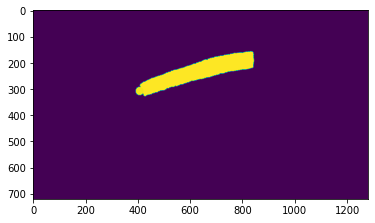

In [53]:
# label = Image.open('/data/input/IMA_root/train/season5_1/case104/palette/frame_022181.png').convert('P')
label = cv2.imread('/data/input/IMA_root/train/season5_1/case104/label/frame_022181.png', 0)
print(np.unique(label))
plt.imshow(label)

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [54]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from glob import glob

In [55]:
CLASSES = {'background': 0, 'IMAroot': 110, 'IMApink': 112}
classes = {'IMApink':1, 'IMAroot':1}
{CLASSES[k]: v for k, v in classes.items()}

{112: 1, 110: 1}

In [56]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = {'background': 0, 'IMAroot': 110, 'IMApink': 112}
    
    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
            binary_output=False
    ):
        self.images_fps = glob(os.path.join(images_dir, '*.png'))
        self.masks_fps = glob(os.path.join(masks_dir, '*.png'))
        
        # convert str names to class values on masks
        if type(classes) == list:
            # classname mapが名前だけの場合
            self.class_values = [self.CLASSES[cls] for cls in classes]
        elif type(classes) == dict:
            # classname mapが名前とclass idの場合
            self.class_values = {self.CLASSES[cls]: v for cls, v in classes.items()}
        else:
            assert "classes's type dict or list only" 
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.binary_output = binary_output
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask
        if type(self.class_values) == list:
            # classname mapが名前だけの場合
            masks = [(mask == k) for k in self.class_values]
        
        elif type(self.class_values) == dict:
            # classname mapが名前とclass idの場合
            for k, v in self.class_values.items():
                # kをvに置き換える
                mask[mask == k] = v
            # TODO: np.unique(list(self.class_values.values())) をスッキリさせたい
            masks = [(mask == v) for v in np.unique(list(self.class_values.values()))]
            
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1 or not self.binary_output:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            # argmax時にbackgroundを下敷きにする
            mask = np.concatenate((background, mask), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        assert len(self.images_fps) == len(self.masks_fps)
        return len(self.masks_fps)

(720, 1280, 2)


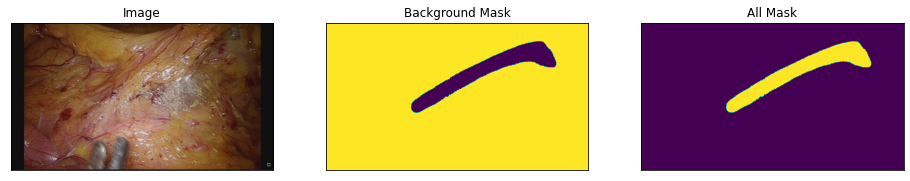

In [57]:
# Lets look at data we have
CLASSES = {'IMApink':1, 'IMAroot':1}
# CLASSES = ['IMApink']
dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES, binary_output=False)

image, mask = dataset[0] # get some sample
print(mask.shape)

visualize(
    image=image, 
    background_mask=mask[..., 0].squeeze(),
#     imapink_mask=mask[..., 1].squeeze(),
#     imaroot_mask=mask[..., 2].squeeze(),
    all_mask=np.argmax(mask, axis=2)
)

In [58]:
len(dataset)

278

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [59]:
import albumentations as albu

In [60]:
def get_training_augmentation():
    train_transform = [
        albu.Resize(height=360, width=640),
        albu.RandomCrop(height=256, width=512, always_apply=True),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(height=540, width=960),
        albu.CenterCrop(height=256, width=512, always_apply=True)
    ]
    return albu.Compose(test_transform)


def resize():
    transform = [
        albu.Resize(height=256, width=512)
    ]
    return albu.Compose(transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    def to_tensor(x, **kwargs):
        return x.transpose(2, 0, 1).astype('float32')
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

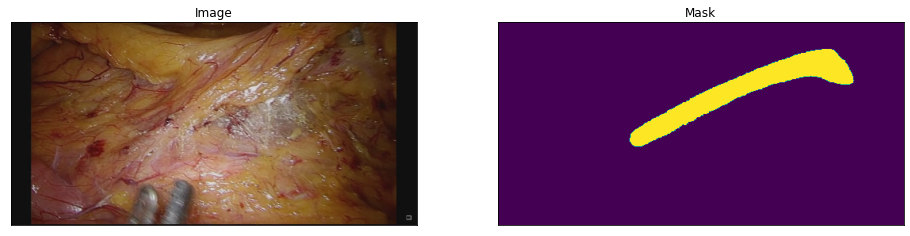

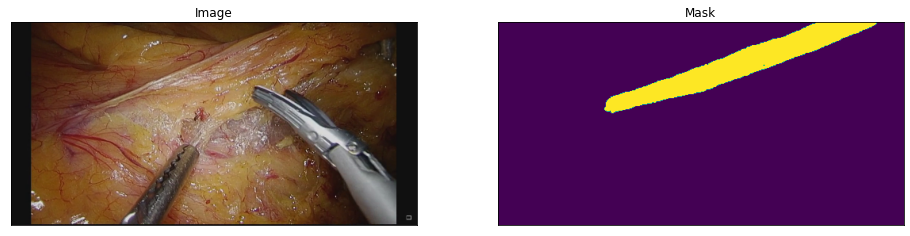

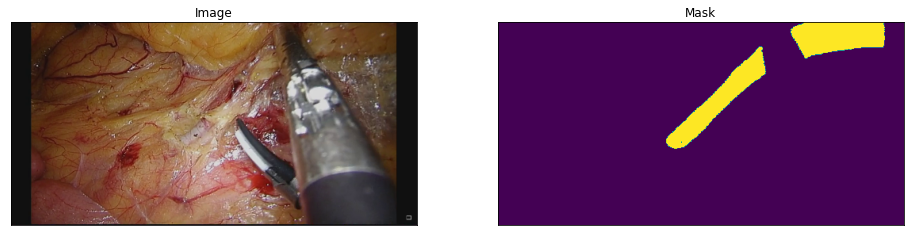

In [61]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=resize(), 
    classes={'IMApink':1, 'IMAroot':1},
)


# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[i]
    visualize(
        image=image, 
#         mask=mask.squeeze()
        mask=np.argmax(mask, axis=2)
     )

## Create model and train

In [62]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [63]:
smp.encoders.resnest_encoders

{'resnest50': {'encoder': segmentation_models_pytorch.encoders.resnest.ResNestEncoder,
  'pretrained_settings': {'imagenet': {'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225],
    'url': 'https://hangzh.s3.amazonaws.com/encoding/models/resnest50-528c19ca.pth',
    'input_space': 'RGB',
    'input_range': [0, 1]}},
  'params': {'block': resnest.torch.resnet.Bottleneck,
   'layers': [3, 4, 6, 3],
   'radix': 2,
   'groups': 1,
   'bottleneck_width': 64,
   'deep_stem': True,
   'stem_width': 32,
   'avg_down': True,
   'avd': True,
   'avd_first': False,
   'out_channels': (3, 64, 256, 512, 1024, 2048)}},
 'resnest101': {'encoder': segmentation_models_pytorch.encoders.resnest.ResNestEncoder,
  'pretrained_settings': {'imagenet': {'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225],
    'url': 'https://hangzh.s3.amazonaws.com/encoding/models/resnest101-22405ba7.pth',
    'input_space': 'RGB',
    'input_range': [0, 1]}},
  'params': {'block': resnest.torch.resne

In [64]:
getattr(smp, 'DeepLabV3')

segmentation_models_pytorch.deeplabv3.model.DeepLabV3

In [65]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = {'IMApink':1, 'IMAroot':1}

n_classes = 1 + 1  # background(1) + objects(len(CLASSES))
ACTIVATION = 'softmax2d' # could be `sigmoid` for binary class or None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'
BATCH_SIZE = 8
LR = 0.0001
EPOCHS = 5

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=n_classes, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [66]:
True if n_classes == 1 else False

False

In [67]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=resize(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    binary_output=True if n_classes == 1 else False
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=resize(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    binary_output=True if n_classes == 1 else False
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2908: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


In [68]:
from segmentation_models_pytorch.utils import functional as F
from segmentation_models_pytorch.utils import base


class MulticlassDiceLoss(base.Loss):
    def __init__(self, class_weights=None, eps=1., beta=1., activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.beta = beta
        self.activation = base.Activation(activation)
        self.ignore_channels = ignore_channels
        self.class_weights = class_weights
    
    def forward(self, y_pred, y_true):
        """
        :param y_pred: shape=(N, C, H, W)
        :param y_true: shape=(N, C, H, W)
        :return : shape=()
        """
        # class_weightsがない場合は1にする
        if self.class_weights is None:
            self.class_weights = torch.ones(y_pred.shape[1]).to('cuda')

        y_pred = self.activation(y_pred)

        dice_loss = 0
        for c in range(y_pred.shape[1]):
            if self.ignore_channels is None or not c in self.ignore_channels:
                dice_loss += self.class_weights[c] * (
                    1 - F.f_score(
                        y_pred[:, c], y_true[:, c],
                        beta=self.beta,
                        eps=self.eps,
                        threshold=None,
                    )
                )

        return dice_loss

In [69]:
torch.manual_seed(0)

y = torch.rand((2, 2, 3, 3)).round().permute((0, 2, 3, 1))
t = torch.randint(2, (2, 2, 3, 3)).permute(0, 2, 3, 1)
w = torch.ones(y.shape[1])

In [70]:
y, t

(tensor([[[[0., 1.],
           [1., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.],
           [1., 0.]],
 
          [[0., 1.],
           [1., 1.],
           [0., 1.]]],
 
 
         [[[0., 0.],
           [0., 0.],
           [1., 0.]],
 
          [[1., 0.],
           [0., 1.],
           [1., 0.]],
 
          [[0., 0.],
           [1., 0.],
           [1., 0.]]]]),
 tensor([[[[0, 1],
           [1, 1],
           [1, 1]],
 
          [[0, 0],
           [0, 1],
           [1, 0]],
 
          [[0, 1],
           [1, 1],
           [1, 1]]],
 
 
         [[[1, 0],
           [0, 1],
           [1, 0]],
 
          [[0, 0],
           [0, 0],
           [1, 0]],
 
          [[1, 0],
           [0, 1],
           [1, 1]]]]))

In [71]:
MulticlassDiceLoss()(y, t)

tensor(1.1042, device='cuda:0')

In [72]:
tp = torch.sum(t * y)
fp = torch.sum(y) - tp
fn = torch.sum(t) - tp
tp, fp, fn

(tensor(10.), tensor(3.), tensor(10.))

In [73]:
x = torch.rand(3,1,3,1,3)
x.squeeze(1).size()

torch.Size([3, 3, 1, 3])

In [74]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

# loss = smp.utils.losses.DiceLoss()
loss = MulticlassDiceLoss([1.0, 1.0])
# loss = smp.utils.losses.BCELoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0]),
    smp.utils.metrics.Fscore(threshold=0.5, ignore_channels=[0]),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=LR),
])

In [75]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [76]:
# train model for 40 epochs

max_score = 0
train_logs = {}
valid_logs = {}

for i in range(0, EPOCHS):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
#         torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 96/96 [00:02<00:00, 44.34it/s, multiclass_dice_loss - 0.5435, iou_score - 0.3626, fscore - 0.5032]
Model saved!

Epoch: 1
valid: 100%|██████████| 96/96 [00:02<00:00, 39.34it/s, multiclass_dice_loss - 0.4815, iou_score - 0.4091, fscore - 0.5525]
Model saved!

Epoch: 2
valid: 100%|██████████| 96/96 [00:02<00:00, 38.16it/s, multiclass_dice_loss - 0.4737, iou_score - 0.4158, fscore - 0.5553]
Model saved!

Epoch: 3
valid: 100%|██████████| 96/96 [00:02<00:00, 45.59it/s, multiclass_dice_loss - 0.4561, iou_score - 0.4356, fscore - 0.5737]
Model saved!

Epoch: 4
valid: 100%|██████████| 96/96 [00:02<00:00, 43.19it/s, multiclass_dice_loss - 0.452, iou_score - 0.4396, fscore - 0.5787] 
Model saved!


In [80]:
valid_logs

{'multiclass_dice_loss': 0.4520084237058958,
 'iou_score': 0.4396087176868718,
 'fscore': 0.578661494267859}

## Test best saved model

In [28]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set 

In [29]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir,
    augmentation=resize(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
#     binary_output=True
)

test_dataloader = DataLoader(test_dataset)

In [30]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 96/96 [00:08<00:00, 11.96it/s, multiclass_dice_loss - 0.2242, iou_score - 0.6777, fscore - 0.7903]


## Visualize predictions

In [31]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir,
    y_test_dir,
    classes=CLASSES,
    binary_output=True if n_classes == 1 else False
)

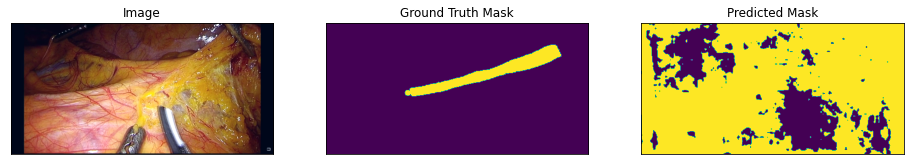

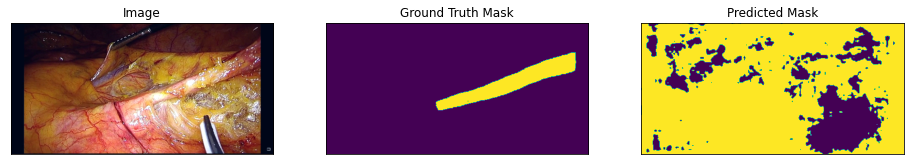

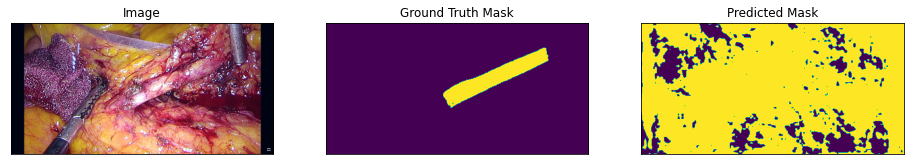

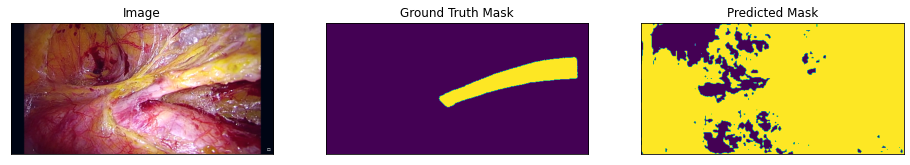

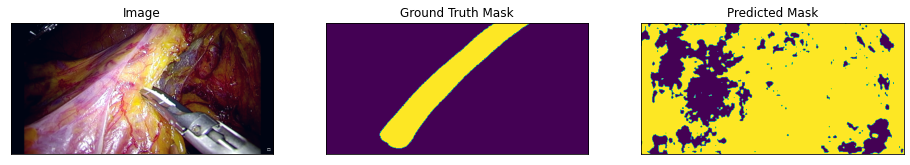

In [32]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    
#     print(gt_mask.shape)
#     print(np.unique(np.argmax(pr_mask, axis=0), return_counts=True))
    image = image.transpose(1, 2, 0)
#     gt_mask = gt_mask.transpose(1, 2, 0)
#     pr_mask = pr_mask.transpose(1, 2, 0)
        
    visualize(
        image=denormalize(image), 
        ground_truth_mask=np.argmax(gt_mask, axis=0), 
#         gt_mask=gt_mask,
#         ima=pr_mask,
        predicted_mask=np.argmax(pr_mask, axis=0)
    )

In [34]:
label = np.argmax(gt_mask, axis=0)

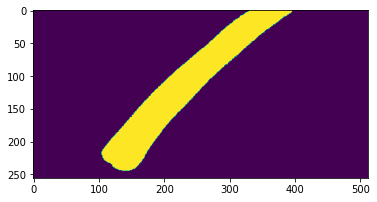

In [35]:
plt.imshow(label)

In [52]:
np.unique(label)

array([  0, 255], dtype=uint8)

In [37]:
label[label == 1] = 255

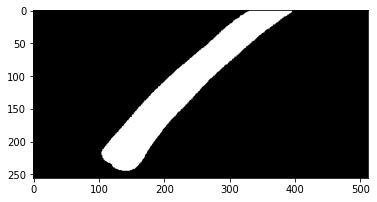

In [86]:
label = label.astype('uint8')
rgb = cv2.cvtColor(label, cv2.COLOR_GRAY2RGB)
plt.imshow(rgb)

In [53]:
rgb.shape

(256, 512, 3)

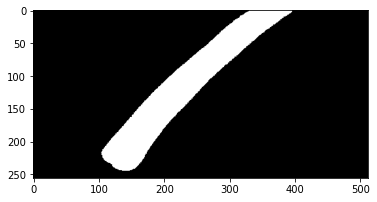

In [46]:
plt.imshow(label, cmap='gray')

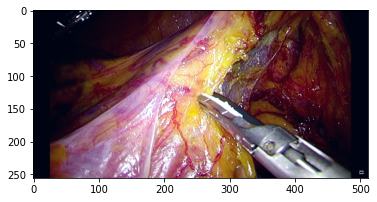

In [106]:
frame = denormalize(image)
frame = (frame*255).astype('uint8')
plt.imshow(frame)

In [107]:
frame.dtype

dtype('uint8')

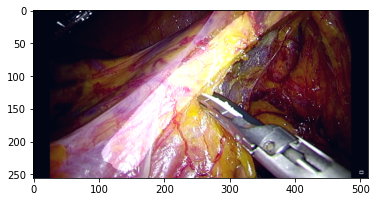

In [181]:
blend = cv2.addWeighted(src1=frame, alpha=1, src2=rgb, beta=0.25, gamma=2.2)
plt.imshow(blend)

In [188]:
def surrounding(frame, mask):
    gray = mask.copy()
    output = frame.copy()
    _, bw = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    if len(contours) == 0:
        return output

    for i in range(0, len(contours)):
        area = cv2.contourArea(contours[i])
        cv2.drawContours(output, contours, i, (0, 255, 0), 2)
        
    return output

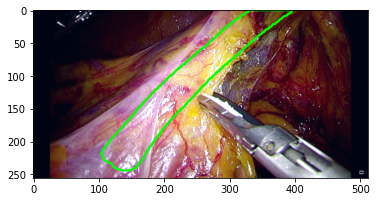

In [189]:
bl = surrounding(frame, label)
plt.imshow(bl)

In [43]:
from albumentations.core.transforms_interface import DualTransform


class CutOff(DualTransform):
    """画面の左右の黒帯を取り除く
    """

    def __init__(self, height, width, always_apply=False, p=1.):
        super().__init__(always_apply, p)
        self.height = height
        self.width = width

    def apply(self, image, **params):
        return image[:, int(self.width * 0.05):int(self.width * 0.95)]
    
    
def get_training_augmentation():
    train_transform = [
        CutOff(height=720, width=1280, always_apply=True),
        albu.Resize(height=350, width=560),
        albu.RandomCrop(height=256, width=512, always_apply=True),
    ]
    return albu.Compose(train_transform)

(256, 512, 3) (256, 512, 2)


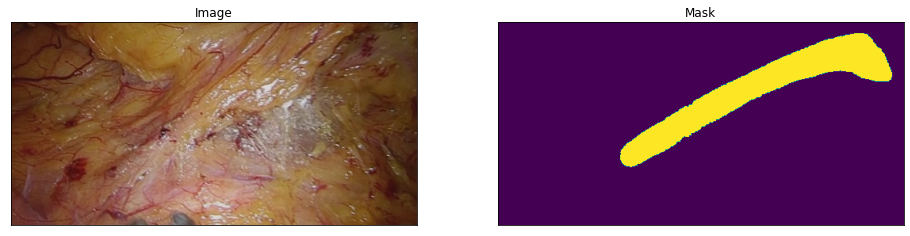

(256, 512, 3) (256, 512, 2)


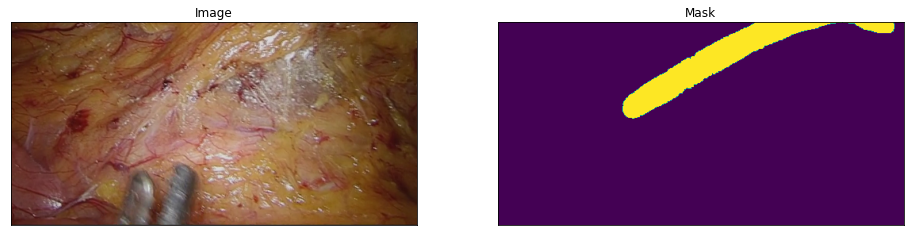

(256, 512, 3) (256, 512, 2)


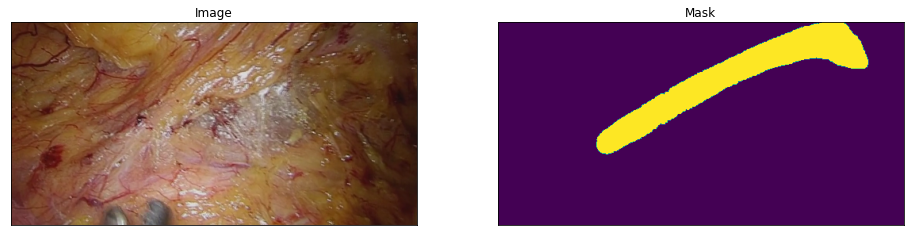

In [47]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes={'IMApink':1, 'IMAroot':1},
)


# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[0]
    print(image.shape, mask.shape)
    visualize(
        image=image, 
#         mask=mask.squeeze()
        mask=np.argmax(mask, axis=2)
     )

In [101]:
c = 2
tp, fp, fn = [np.zeros(c) for _ in range(3)]

In [104]:
tp[0] = 4
tp[1] = 1
fp[0] = 3
fn[1] = 2

In [105]:
tp, fp, fn

(array([4., 1.]), array([3., 0.]), array([0., 2.]))

In [106]:
d = 2 * tp / (2 * tp + fp + fn)

In [109]:
d[1:].mean()

0.5

In [221]:
a = np.zeros((0, 2))

In [226]:
a.shape

(3, 2)

In [225]:
a = np.append(a, d[np.newaxis], axis=0)
a

array([[0.72727273, 0.5       ],
       [0.72727273, 0.5       ],
       [0.72727273, 0.5       ]])

In [228]:
df = pd.DataFrame(a)

In [229]:
df

,0,1
0,0.727273,0.5
1,0.727273,0.5
2,0.727273,0.5


ValueError: x and y must have same first dimension, but have shapes (3,) and (1,)

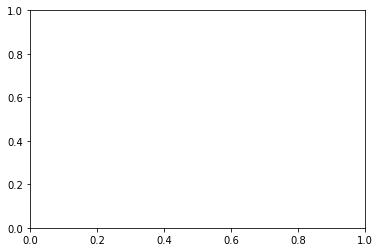

In [120]:
for c in range(len(d)):
    plt.plot(np.arange(3), d[c])
plt.show()

In [155]:
s = torch.rand(1, 2, 256, 512)

In [158]:
s[:,0].shape

torch.Size([1, 256, 512])

In [159]:
for i in range(2):
    print(i)

0
1
